# آزمون خطی بودن

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nlntest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import bds
import yfinance as yf       # https://pypi.org/project/yfinance/
import pytse_client as tse # https://pypi.org/project/pytse-client/

## دریافت داده

این بخش در تمرین شماره یک انجام گرفته و از همان کدها استفاده می‌شود.

دیتای اینتل و والمارت از api یاهوفایننس دریافت می‌شود:

In [2]:
tickers = ['INTC', 'WMT']
data_nse = yf.download(tickers, group_by = 'ticker', start="2017-01-01", end="2022-11-19")

[*********************100%***********************]  2 of 2 completed


دیتای دو سهم ایرانی شپنا و وبصادر نیز از سایت tse اسکریپ می‌شود:

In [118]:
tickers = ['خودرو', 'شپنا']
prices_dict = tse.download(symbols=tickers, adjust=True)
prices_dict_reform = {(outerKey, innerKey):
                             values for outerKey, innerDict 
                             in prices_dict.items() for innerKey, values 
                             in innerDict.iteritems()}
data_tse = pd.DataFrame(prices_dict_reform)
d = {'خودرو': 'Khodro', 'شپنا': 'Shepna'}
data_tse = data_tse.rename(columns=d, level=0)

## آشنایی با داده

نگاهی به دیتای شرکت اینتل می‌اندازیم:

In [119]:
data_nse['INTC'][['Open', 'High', 'Low', 'Close', 'Adj Close']].tail()

,Open,High,Low,Close,Adj Close
Date,,,,,
2022-11-14,30.340000,30.990000,30.180000,30.350000,30.350000
2022-11-15,31.100000,31.340000,30.170000,30.709999,30.709999
2022-11-16,30.110001,30.230000,29.440001,29.530001,29.530001
2022-11-17,29.070000,29.950001,29.000000,29.889999,29.889999
2022-11-18,30.260000,30.260000,29.610001,29.870001,29.870001


نگاهی به دیتای شرکت خودرو می‌اندازیم:

In [141]:
cols = ['open', 'high', 'low', 'close', 'adjClose']
data_tse['Khodro'].set_index('date')[cols].tail()

,open,high,low,close,adjClose
date,,,,,
2022-11-12,2230.0,2240.0,2157.0,2163.0,2188.0
2022-11-13,2152.0,2204.0,2123.0,2148.0,2159.0
2022-11-14,2160.0,2183.0,2109.0,2110.0,2135.0
2022-11-15,2173.0,2219.0,2151.0,2179.0,2180.0
2022-11-16,2189.0,2228.0,2152.0,2192.0,2200.0


نمودار شرکت اینتل را در یک سال آخر رسم می‌کنیم تا با حرکت کلی سهم آشنا شویم:

<AxesSubplot:title={'center':'Adj Close for INTC'}, xlabel='Date'>

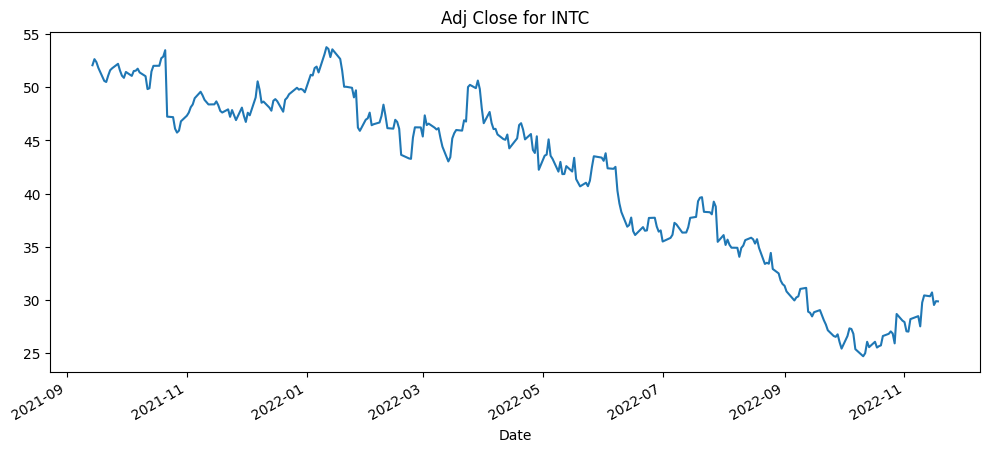

In [121]:
data_nse['INTC', 'Adj Close'][-300:].plot(title='Adj Close for INTC', figsize=(12,5))

## مدل‌سازی

### تست ایستا بودن دیفرنس قیمت‌ها

برای اینکه بدانیم آیا سری قیمت‌ها با یک‌بار دیفرنس گرفتن ایستا می‌شوند، تست ADF را انجام می‌دهیم و در صورتی که pvalue این تست کم‌تر از پنج‌درصد باشد، فرض صفر را رد می‌کنیم و سری را ایستا در نظر می‌گیریم.

در صورتی که سری با یک بار دیفرنس گرفتن ایستا شود، 
بعدا در مدل ARIMA مقدار d را برابر با یک قرار می‌دهیم.

:تست ایستا بودن دیفرنس قیمت‌های اینتل

In [123]:
diff_adjClose = data_nse['INTC', 'Adj Close'].diff()
adfuller(np.array(diff_adjClose)[1:])[1] < 0.05

True

:تست ایستا بودن دیفرنس قیمت‌های والمارت

In [124]:
diff_adjClose = data_nse['WMT', 'Adj Close'].diff()
adfuller(np.array(diff_adjClose)[1:])[1] < 0.05

True

:تست ایستا بودن دیفرنس قیمت‌های خودرو

In [126]:
diff_adjClose = data_tse['Khodro', 'adjClose'].diff()
diff_adjClose = diff_adjClose[~np.isnan(diff_adjClose)]
adfuller(diff_adjClose) [1] < 0.05

True

:تست ایستا بودن دیفرنس قیمت‌های شپنا

In [127]:
diff_adjClose = data_tse['Shepna', 'adjClose'].diff()
diff_adjClose = diff_adjClose[~np.isnan(diff_adjClose)]
adfuller(diff_adjClose) [1] < 0.05

True

همگی سری‌های قیمتی با یک بار دیفرنس گرفتن ایستا می‌شوند؛ بنابراین می‌توانیم در مدل ARIMA مقدار d را برای همگی یک در نظر بگیریم.



برای یافتن بهترین مدل، یک تابع می‌نویسیم. این تابع مدل‌های ARIMA مختلف را امتحان می‌کند و مدلی را که کم‌ترین aic دارد به عنوان خروجی پس می‌دهد.

In [144]:
def best_arima(data):
    p_max = 12
    min_aic = np.inf
    best_model = None
    for p in range(1, p_max):
        model = ARIMA(data, order=(p, 1, 0)).fit()
        if min_aic > model.aic:
            min_aic = model.aic
            best_model = model
        
    return best_model

## نتایج

### سهم خودرو

پس از گرفتن مانده‌ بهترین مدل ARIMA تست خطی بودن را اجرا می‌کنیم.

نتیجه: همه آزمون‌های خطی، فرض صفر را رد کرده‌اند. بنابراین سری قیمتی خودرو، رفتاری غیرخطی دارد.

In [129]:
symbol = 'Khodro'
not_null_data = data_tse[data_tse[symbol, 'adjClose'].notna()][symbol, 'adjClose']
arim_model = best_arima(not_null_data)
residuals1 = arim_model.resid
nlntest.nlntstuniv(np.array(residuals1))


------------------ Linearity Test of Univariate time Series--------------------

H0: Model is linear,  PValue of Ramsey Test             1.1102230246251565e-16
H0: Model is linear,  PValue of Keenan Test             1.1102230246251565e-16
H0: Model is linear,  PValue of Tsay Test               1.1102230246251565e-16
H0: Model is linear,  PValue of Terasvirta et al. Test  1.1102230246251565e-16
-------------------------------------------------------------------------------
Ref. Mohammadi S.(2019). Neural network for univariate and multivariate nonlinearity tests. Stat Anal Data Min: The ASA DataSci Journal.13:50-70. https://doi.org/10.1002/sam.11441


(array([1.11022302e-16]),
 array([1.11022302e-16]),
 array([1.11022302e-16]),
 array([1.11022302e-16]))

### سهم شپنا

پس از گرفتن مانده‌ بهترین مدل ARIMA تست خطی بودن را اجرا می‌کنیم.

نتیجه: همه آزمون‌های خطی، فرض صفر را رد کرده‌اند. بنابراین سری قیمتی شپنا، رفتاری غیرخطی دارد.

In [131]:
symbol = 'Shepna'
not_null_data = data_tse[data_tse[symbol, 'adjClose'].notna()][symbol, 'adjClose']
arim_model = best_arima(not_null_data)
residuals = arim_model.resid
nlntest.nlntstuniv(np.array(residuals))


------------------ Linearity Test of Univariate time Series--------------------

H0: Model is linear,  PValue of Ramsey Test             1.1102230246251565e-16
H0: Model is linear,  PValue of Keenan Test             2.9976021664879227e-15
H0: Model is linear,  PValue of Tsay Test               2.9976021664879227e-15
H0: Model is linear,  PValue of Terasvirta et al. Test  1.1102230246251565e-16
-------------------------------------------------------------------------------
Ref. Mohammadi S.(2019). Neural network for univariate and multivariate nonlinearity tests. Stat Anal Data Min: The ASA DataSci Journal.13:50-70. https://doi.org/10.1002/sam.11441


(array([1.11022302e-16]),
 array([2.99760217e-15]),
 array([2.99760217e-15]),
 array([1.11022302e-16]))

### سهم اینتل

پس از گرفتن مانده‌ بهترین مدل ARIMA تست خطی بودن را اجرا می‌کنیم.

نتیجه: هیچ‌کدام از آزمون‌های خطی، فرض صفر را رد نکرده‌اند. بنابراین سری قیمتی اینتل، رفتاری خطی دارد.

In [137]:
symbol = 'INTC'
not_null_data = data_nse[data_nse[symbol, 'Adj Close'].notna()][symbol, 'Adj Close']
not_null_data = np.array(not_null_data)
arim_model = best_arima(not_null_data)
residuals = arim_model.resid
nlntest.nlntstuniv(np.array(residuals))


------------------ Linearity Test of Univariate time Series--------------------

H0: Model is linear,  PValue of Ramsey Test             0.12002599396046165
H0: Model is linear,  PValue of Keenan Test             0.48056564883432895
H0: Model is linear,  PValue of Tsay Test               0.48056564883432984
H0: Model is linear,  PValue of Terasvirta et al. Test  0.02576320329911097
-------------------------------------------------------------------------------
Ref. Mohammadi S.(2019). Neural network for univariate and multivariate nonlinearity tests. Stat Anal Data Min: The ASA DataSci Journal.13:50-70. https://doi.org/10.1002/sam.11441


(array([0.12002599]),
 array([0.48056565]),
 array([0.48056565]),
 array([0.0257632]))

### سهم والمارت

پس از گرفتن مانده‌ بهترین مدل ARIMA تست خطی بودن را اجرا می‌کنیم.

نتیجه: آزمون ترسورتا فرض صفر را کرده است. اما سه آزمون دیگر در سطح اطمینان ۹۵ درصد فرض صفر را رد نکرده‌اند. هر چند تست رمزی نیز بسیار به مقدار بحرانی نیزدیک است.
در مورد سری قیمتی والمارت نمی‌توان با قطعیت نظر دارد.

In [138]:
symbol = 'WMT'
not_null_data = data_nse[data_nse[symbol, 'Adj Close'].notna()][symbol, 'Adj Close']
not_null_data = np.array(not_null_data)
arim_model = best_arima(not_null_data)
residuals = arim_model.resid
nlntest.nlntstuniv(np.array(residuals))


------------------ Linearity Test of Univariate time Series--------------------

H0: Model is linear,  PValue of Ramsey Test             0.005049658765449827
H0: Model is linear,  PValue of Keenan Test             0.7167640875642718
H0: Model is linear,  PValue of Tsay Test               0.7167640875642678
H0: Model is linear,  PValue of Terasvirta et al. Test  0.0005997956456036402
-------------------------------------------------------------------------------
Ref. Mohammadi S.(2019). Neural network for univariate and multivariate nonlinearity tests. Stat Anal Data Min: The ASA DataSci Journal.13:50-70. https://doi.org/10.1002/sam.11441


(array([0.00504966]),
 array([0.71676409]),
 array([0.71676409]),
 array([0.0005998]))